In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
userdata = pd.read_csv('../dataset/User-AnimeReview.csv')
userdata.head()



,user_id,anime_id,score,status,episodes_seen
0,doobiez420,52991,NaN,Watching,13.0
1,LessKk,52991,NaN,Watching,12.0
2,ByAsh156,52991,9.0,Watching,NaN
3,ShuBoxx_,52991,NaN,Plan to Watch,NaN
4,charlieleb,52991,8.0,Completed,28.0


In [3]:
print("Number of rows before dropping duplicates:", len(userdata))
userdata.isna().sum()


Number of rows before dropping duplicates: 16573880


user_id                40
anime_id                0
score            10968315
status              14352
episodes_seen     7611899
dtype: int64

In [4]:
userdata.nunique()

user_id          1196322
anime_id           27702
score                 10
status                 5
episodes_seen        764
dtype: int64

In [5]:
print(userdata['episodes_seen'].value_counts())

episodes_seen
1.0       4196418
12.0       949371
2.0        668619
13.0       464505
3.0        280669
           ...   
2573.0          1
3589.0          1
2514.0          1
590.0           1
678.0           1
Name: count, Length: 764, dtype: int64


In [25]:
nandropped = userdata.copy()
nandropped.dropna(inplace=True)

In [7]:
nandropped.nunique()

user_id          607477
anime_id          27381
score                10
status                4
episodes_seen       697
dtype: int64

In [7]:
nandropped.to_csv('cleaned_userdata.csv', index=False)

In [8]:
nandropped.describe()

,anime_id,score,episodes_seen
count,5.454899e+06,5.454899e+06,5.454899e+06
mean,2.806141e+04,6.645204e+00,8.098657e+01
std,1.875091e+04,2.260999e+00,2.129579e+03
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,8.697000e+03,5.000000e+00,1.000000e+00
50%,3.185900e+04,7.000000e+00,2.000000e+00
75%,4.161200e+04,8.000000e+00,1.200000e+01
max,6.173000e+04,1.000000e+01,6.553500e+04


In [8]:
print(nandropped[nandropped['episodes_seen'] > 1000].describe())

           anime_id        score  episodes_seen
count   7946.000000  7946.000000    7946.000000
mean   26751.196954     2.200227   48620.191417
std    14843.742749     2.568347   27448.708689
min       21.000000     1.000000    1001.000000
25%    10241.000000     1.000000    9999.000000
50%    30207.500000     1.000000   65535.000000
75%    38321.750000     1.000000   65535.000000
max    61420.000000    10.000000   65535.000000


In [9]:
pd.set_option('display.max_rows', 500)   # or None for unlimited
pd.set_option('display.max_colwidth', None)  # prevent column truncation


In [10]:
rating_std = nandropped.groupby('user_id')['score'].std()
uniform_users = rating_std[rating_std < 0.3].index
print(len(uniform_users))

51068


In [11]:
review_counts = nandropped['user_id'].value_counts()
heavy_users = review_counts[review_counts > 1200].index
# print(heavy_users)
print(len(heavy_users))

305


In [12]:
mask = (nandropped['episodes_seen'] == 1) 

trolls = nandropped.loc[mask]

len(trolls)

2620011

In [10]:
nandropped.columns


Index(['user_id', 'anime_id', 'score', 'status', 'episodes_seen'], dtype='object')

In [14]:
troll_users = trolls['user_id'].unique()
print(troll_users)
print(len(troll_users))

['nxptunzzz' 'ralphkitzer' 'mochidays-' ... 'jojawopon' 'TheMiseryChick'
 'benny566']
354038


In [27]:
trolls.describe()

,anime_id,score,episodes_seen
count,2.620011e+06,2.620011e+06,2620011.0
mean,2.872176e+04,6.252697e+00,1.0
std,1.846814e+04,2.306005e+00,0.0
min,1.000000e+00,1.000000e+00,1.0
25%,9.716000e+03,5.000000e+00,1.0
50%,3.175700e+04,6.000000e+00,1.0
75%,4.174400e+04,8.000000e+00,1.0
max,6.173000e+04,1.000000e+01,1.0


In [13]:
trolls.head(n = 20)

,user_id,anime_id,score,status,episodes_seen
12407798,SamLuv,10241,2.0,Completed,1006.0
12407807,L7_Jinzo,10241,2.0,Completed,1006.0
12408007,seth,10241,2.0,Completed,1006.0
12408157,Zsingp,10241,2.0,Completed,1006.0
12408224,api_madman9512,10241,2.0,Completed,1006.0


In [16]:
animedata = pd.read_csv('../somewhatcleanedAnime.csv')

In [17]:
len(animedata)

23355

In [18]:
anime_episode_estimates = {}

# Filter completed watch statuses (if such a column exists)
completed_data = nandropped[nandropped['status'] == 'Completed']  # or status code == 2, depending on source

# Group by anime_id
grouped = completed_data.groupby('anime_id')

for anime_id, group in grouped:
    mode_eps = group['episodes_seen'].mode()
    if not mode_eps.empty:
        anime_episode_estimates[anime_id] = int(mode_eps[0])

In [19]:
print(len(anime_episode_estimates))

27318


In [26]:
# Step 1: Get mode episodes per anime from completed users
completed = nandropped[nandropped['status'] == 'Completed']
episode_mode = completed.groupby('anime_id')['episodes_seen'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
episode_mode.name = 'estimated_max_eps'

# Step 2: Merge this info back into userAnime
nandropped = nandropped.merge(episode_mode, on='anime_id', how='left')

# Step 3: Create mask for users who watched more than estimated max
nandropped['suspicious'] = (
    (nandropped['episodes_seen'] > nandropped['estimated_max_eps']) &
    (nandropped['episodes_seen'] > 1300)
)

# Step 4: View those suspicious rows


print(f"Total suspicious rows: {nandropped['suspicious'].sum()}")
  # Or suspicious_users[['user_id', 'anime_id', 'episodes_seen', 'estimated_max_eps']]


Total suspicious rows: 6471


In [27]:
# Drop suspicious only
print(len(nandropped))
nandropped = nandropped[~nandropped['suspicious']].drop(columns=['suspicious', 'estimated_max_eps']).reset_index(drop=True)
print(len(nandropped))

5454899
5448428


In [28]:
user_activity_counts = nandropped['user_id'].value_counts()
low_activity_users = user_activity_counts[user_activity_counts < 10].index
low_activity_mask = nandropped['user_id'].isin(low_activity_users)


In [29]:
user_score_std = nandropped.groupby('user_id')['score'].std()
low_std_users = user_score_std[user_score_std < 1].index  # or < 0.5 if you want a more relaxed filter
low_std_mask = nandropped['user_id'].isin(low_std_users)


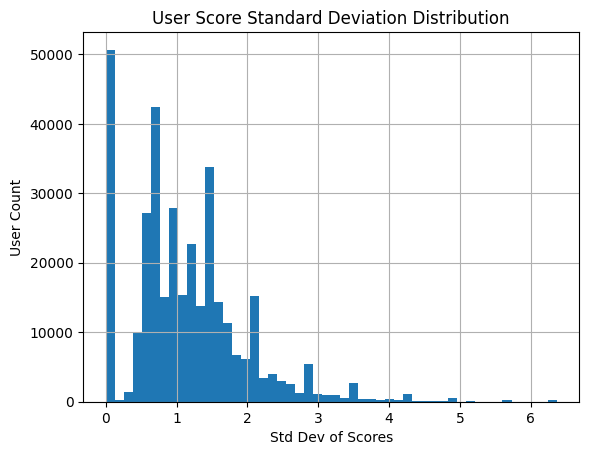

In [30]:
user_score_std.hist(bins=50)
plt.title("User Score Standard Deviation Distribution")
plt.xlabel("Std Dev of Scores")
plt.ylabel("User Count")
plt.show()


In [31]:
print(f"Low activity users: {len(low_activity_users)}")
print(f"Low score std users: {len(low_std_users)}")
print(f"Overlap: {len(set(low_activity_users) & set(low_std_users))}")


Low activity users: 530472
Low score std users: 164304
Overlap: 140673


In [32]:
# Combine masks
combined_user_mask = low_activity_mask | low_std_mask

# Preview how many rows affected
print(f"Rows to drop: {combined_user_mask.sum()}")

# Drop
nandropped = nandropped[~combined_user_mask].reset_index(drop=True)


Rows to drop: 2555853


In [57]:
nandropped.nunique()

user_id          53350
anime_id         27264
score               10
status               4
episodes_seen      565
dtype: int64

In [58]:
print(len(nandropped))

2892484


In [33]:
# Load the list of valid anime_ids from somewhatcleanedAnime.csv
valid_anime = pd.read_csv('../somewhatcleanedAnime.csv')  # adjust path if needed
valid_anime_ids = set(valid_anime['anime_id'])

# Filter nandropped to only include these anime_ids
final_df = nandropped[nandropped['anime_id'].isin(valid_anime_ids)].reset_index(drop=True)

In [34]:
print(len(final_df))

final_df['anime_id'].nunique()

2211681


22482

In [42]:
review_counts_per_anime = final_df['anime_id'].value_counts()
print(review_counts_per_anime.to_string())

anime_id
35760    2401
38000    2391
11757    2383
31964    2366
47778    2346
48561    2328
33486    2311
21881    2303
34134    2301
40748    2300
23755    2291
25777    2289
38524    2254
32281    2254
27899    2243
22319    2231
40028    2230
44511    2229
28851    2174
32937    2111
199      2107
50265    2096
16498    2089
48583    2087
30831    2043
37450    2039
4224     2035
42897    2032
1535     2021
431      2015
30654    1999
37999    1995
36511    1990
32182    1975
24833    1975
51009    1967
35849    1965
22199    1952
10620    1939
37510    1911
34933    1910
31043    1908
37430    1897
20       1884
39551    1881
11111    1857
38691    1855
6547     1845
32       1825
31240    1810
38040    1810
42310    1803
26055    1797
49596    1795
55016    1779
9919     1763
52034    1752
20583    1740
37991    1738
20507    1731
28891    1724
36098    1721
33206    1718
43608    1716
40852    1713
22535    1706
9989     1694
50172    1688
40456    1685
37521    1681
33255    16

In [43]:
# Filter out anime_ids with fewer than 76 reviews
enough_reviews = review_counts_per_anime[review_counts_per_anime >= 76].index
final_df = final_df[final_df['anime_id'].isin(enough_reviews)].reset_index(drop=True)
print(f"Remaining rows: {len(final_df)}")
# print(f"Remaining unique anime: {final_df['anime_id'].nunique()}")

Remaining rows: 1900982


In [44]:
final_df['anime_id'].nunique()

10956

In [45]:
final_df.to_csv('new_cleaned_userdata.csv', index=False)

In [73]:
final_df.drop(columns=['status','episodes_seen'])       

,user_id,anime_id,score
0,charlieleb,52991,8.0
1,Celinho,52991,9.0
2,bolcio,52991,10.0
3,Jhin123,52991,10.0
4,Frfri,52991,10.0
...,...,...,...
2211591,Coolest1234D,51154,1.0
2211592,BBloodhound,51154,8.0
2211593,synraul,51154,6.0
2211594,ak47123,51154,8.0


In [74]:
final_df.to_csv('final_user_anime.csv', index=False)

In [75]:
# Load genres from somewhatcleanedAnime.csv
anime_genres = pd.read_csv('../somewhatcleanedAnime.csv')[['anime_id', 'genre']]

# Merge genres into final_df
final_df = final_df.merge(anime_genres, on='anime_id', how='left')

# Save to CSV with genres included
final_df.isna().sum()


user_id              0
anime_id             0
score                0
status               0
episodes_seen        0
genre            15572
dtype: int64

In [77]:
final_df.dropna(inplace=True)
final_df.isna().sum()

user_id          0
anime_id         0
score            0
status           0
episodes_seen    0
genre            0
dtype: int64

In [78]:
final_df.to_csv('final_user_anime_genres.csv', index=False)